In [1]:
# 1. IMPORTS & SETUP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.stats import kruskal
import warnings
warnings.filterwarnings('ignore')

# Configurações visuais
plt.rcParams['figure.figsize'] = (14, 6)
sns.set_theme(style='whitegrid')
PALETTE = ['#2196F3', '#FF5722', '#4CAF50', '#9C27B0', '#FF9800']

In [2]:
# 2. CARREGANDO OS DADOS

df = pd.read_csv('../data/CreditCardCustomerData.csv')

print(f"Shape: {df.shape[0]} linhas × {df.shape[1]} colunas")
print("Colunas:", df.columns.tolist())
df.head()

Shape: 660 linhas × 7 colunas
Colunas: ['Sl_No', 'Customer Key', 'Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [3]:
# 3. PRÉ-PROCESSAMENTO

# 3.1 Remoção de colunas irrelevantes e duplicatas
df_clean = df.drop(columns=['Sl_No', 'Customer Key'], errors='ignore')
df_clean = df_clean.drop_duplicates()
print(f"Shape após limpeza: {df_clean.shape}")

# 3.2 Definindo variáveis para clusterização
num_cols = ['Avg_Credit_Limit', 'Total_Credit_Cards', 
            'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']


Shape após limpeza: (649, 5)


In [4]:
# 4. ANÁLISE EXPLORATÓRIA

# 4.1 Estatísticas descritivas
estatisticas = df_clean[num_cols].describe().T.round(2)
estatisticas = estatisticas.rename(columns={'50%': 'median'})
print(estatisticas)

print("\nINTERPRETAÇÃO RÁPIDA:")
print("  Limite de crédito: média R$ 34,5k, mas metade tem até R$ 18k (desigualdade)")
print("  Cartões: média de 4,7 cartões por cliente")
print("  Atendimento: banco (2,4), online (2,6), telefone (3,6)")
print("  Clientes com limite alto puxam a média pra cima")

                     count      mean       std     min      25%   median  \
Avg_Credit_Limit     649.0  34878.27  37813.74  3000.0  11000.0  18000.0   
Total_Credit_Cards   649.0      4.71      2.17     1.0      3.0      5.0   
Total_visits_bank    649.0      2.40      1.63     0.0      1.0      2.0   
Total_visits_online  649.0      2.62      2.95     0.0      1.0      2.0   
Total_calls_made     649.0      3.59      2.88     0.0      1.0      3.0   

                         75%       max  
Avg_Credit_Limit     49000.0  200000.0  
Total_Credit_Cards       6.0      10.0  
Total_visits_bank        4.0       5.0  
Total_visits_online      4.0      15.0  
Total_calls_made         5.0      10.0  

INTERPRETAÇÃO RÁPIDA:
  Limite de crédito: média R$ 34,5k, mas metade tem até R$ 18k (desigualdade)
  Cartões: média de 4,7 cartões por cliente
  Atendimento: banco (2,4), online (2,6), telefone (3,6)
  Clientes com limite alto puxam a média pra cima


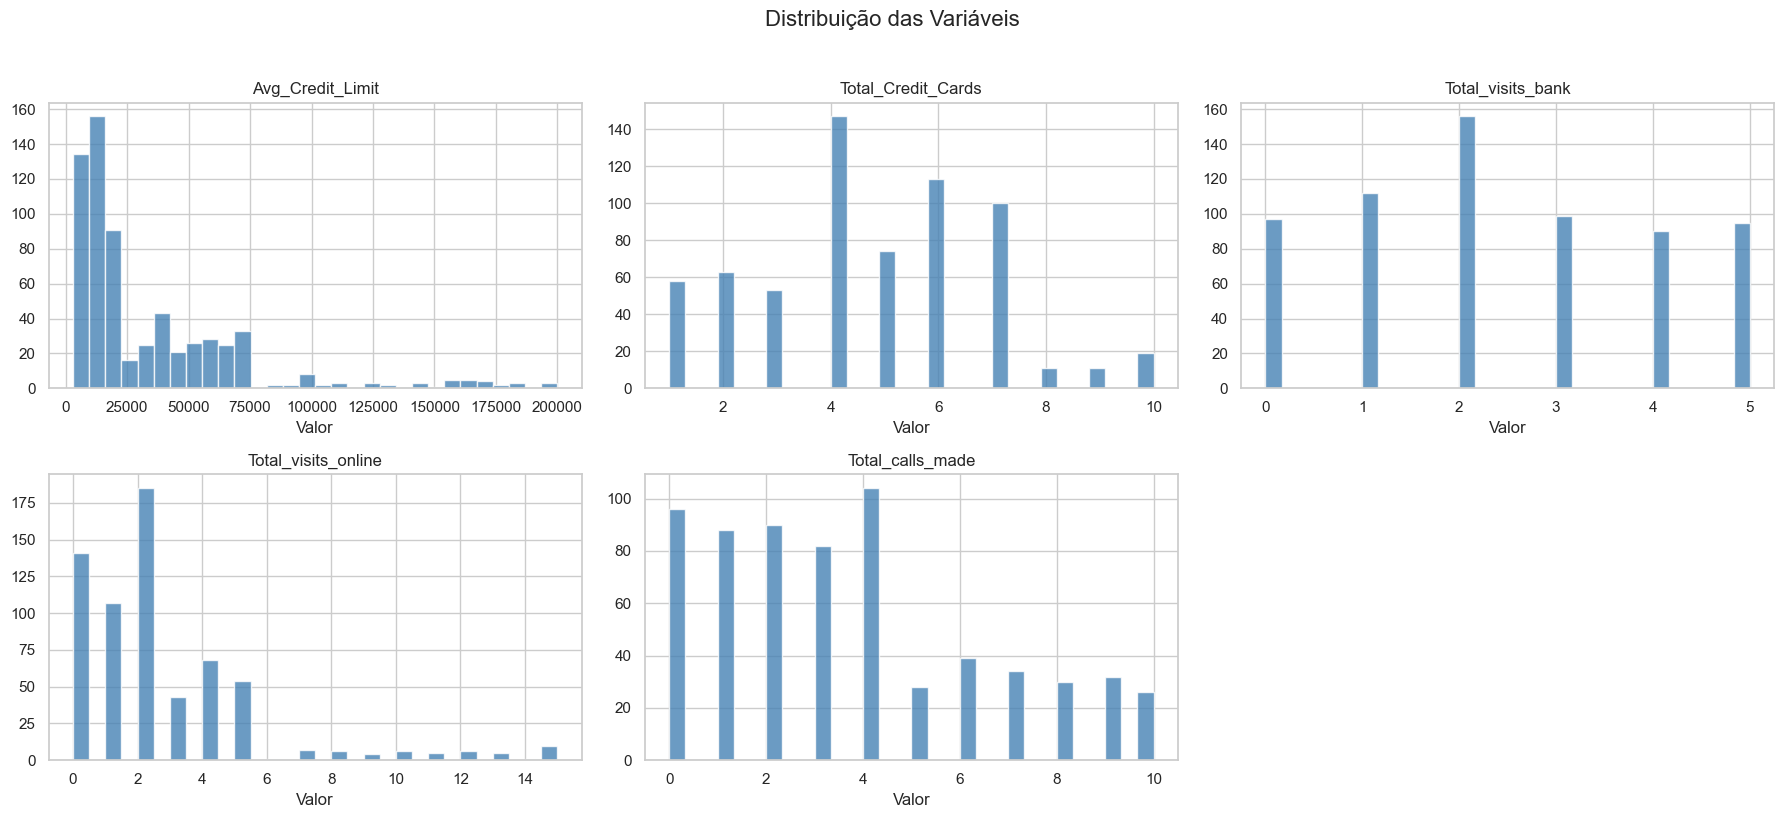

In [5]:
# 4.2 Distribuições

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].hist(df_clean[col].dropna(), bins=30, color='steelblue', 
                 edgecolor='white', alpha=0.8)
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('Valor')

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distribuição das Variáveis', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


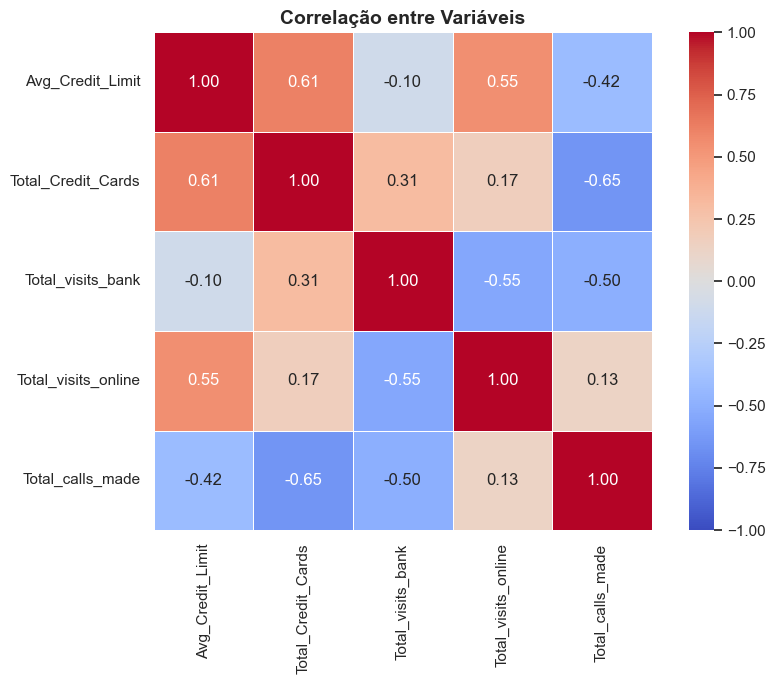


INTERPRETAÇÃO DA CORRELAÇÃO:
  Quem tem mais limite, tem mais cartões (0.61)
  Quem usa online, NÃO usa banco (-0.55)
  Quem tem mais cartões, NÃO liga (-0.65)
  Três perfis distintos: digital, tradicional e misto


In [6]:
# 4.3 Matriz de correlação

plt.figure(figsize=(9, 7))
sns.heatmap(df_clean[num_cols].corr(), annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, vmin=-1, vmax=1, 
            square=True, linewidths=0.5)
plt.title('Correlação entre Variáveis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nINTERPRETAÇÃO DA CORRELAÇÃO:")
print("  Quem tem mais limite, tem mais cartões (0.61)")
print("  Quem usa online, NÃO usa banco (-0.55)")
print("  Quem tem mais cartões, NÃO liga (-0.65)")
print("  Três perfis distintos: digital, tradicional e misto")

In [7]:
# 4.4 Análise de outliers

outliers_df = []
for col in num_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_clean[(df_clean[col] < Q1 - 1.5*IQR) | (df_clean[col] > Q3 + 1.5*IQR)]
    pct = len(outliers) / len(df_clean) * 100
    outliers_df.append([col, len(outliers), f"{pct:.2f}%"])

print(pd.DataFrame(outliers_df, columns=['Variável', 'Qtd', '%']).to_string(index=False))
print("\nApenas limite e visitas online têm outliers (~6%, representam clientes especiais)")

           Variável  Qtd     %
   Avg_Credit_Limit   38 5.86%
 Total_Credit_Cards    0 0.00%
  Total_visits_bank    0 0.00%
Total_visits_online   37 5.70%
   Total_calls_made    0 0.00%

Apenas limite e visitas online têm outliers (~6%, representam clientes especiais)


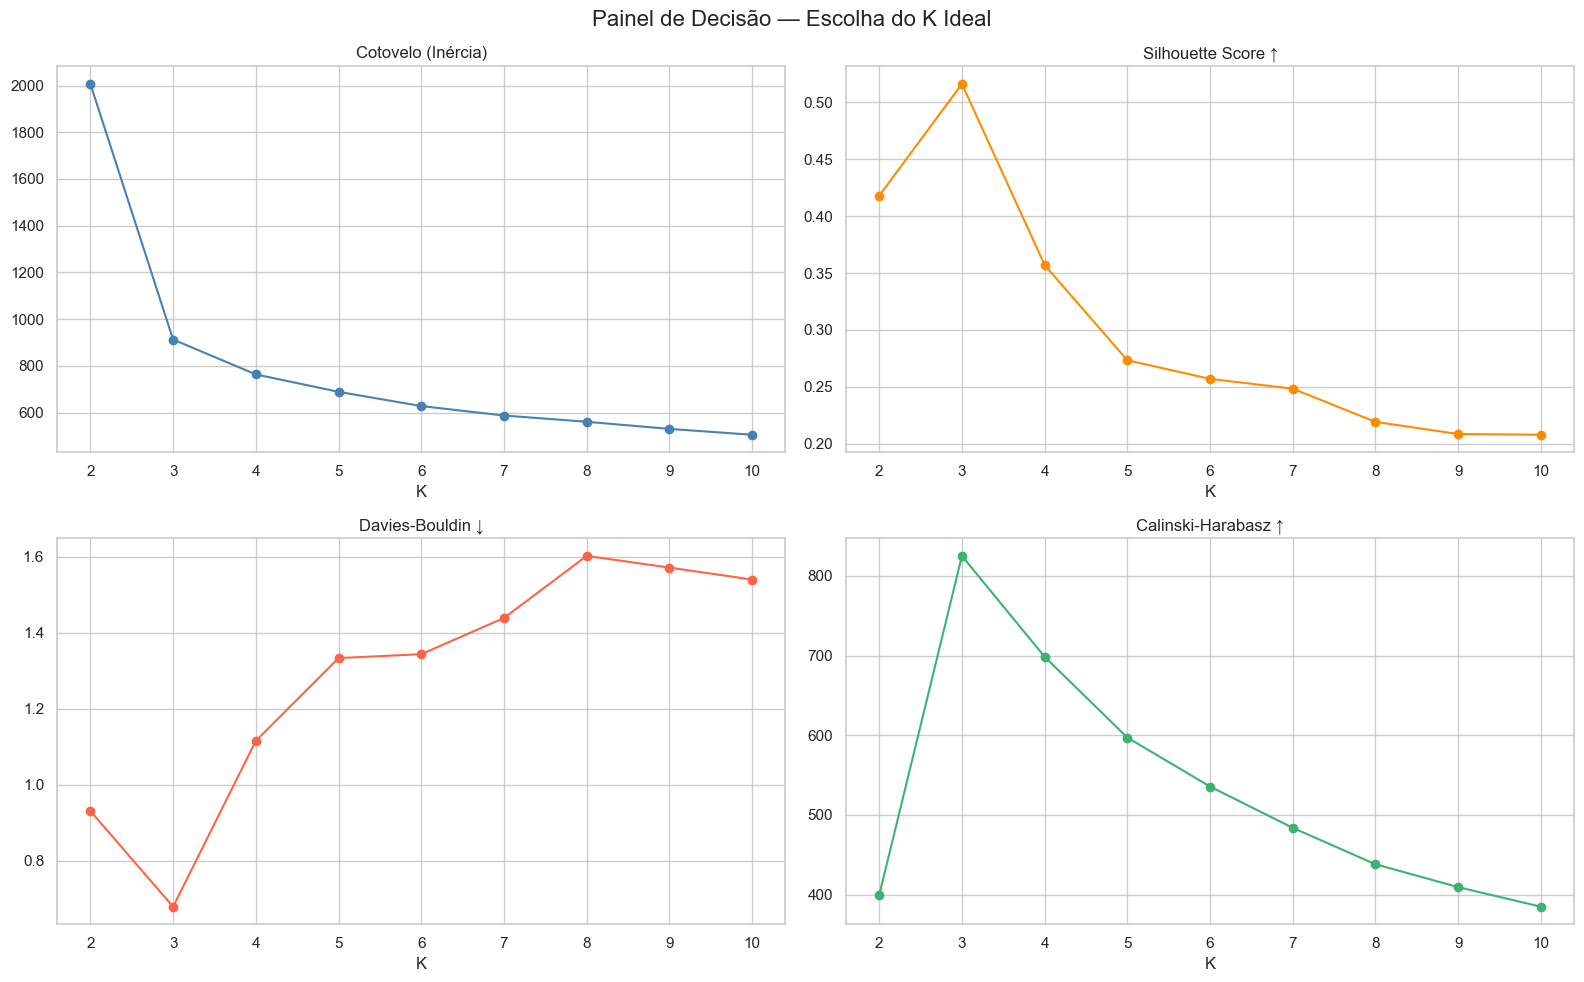


MELHOR K SEGUNDO CADA MÉTODO:
Silhueta: K = 3
Davies-Bouldin: K = 3
Calinski-Harabasz: K = 3

K = 3 foi escolhido (equilíbrio entre os métodos)


In [8]:
# 5. CLUSTERIZAÇÃO

# 5.1 Padronização
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean[num_cols])

# 5.2 Escolha do K (painel de decisão)
k_range = range(2, 11)
inertias, sil_scores, db_scores, ch_scores = [], [], [], []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(df_scaled, labels))
    db_scores.append(davies_bouldin_score(df_scaled, labels))
    ch_scores.append(calinski_harabasz_score(df_scaled, labels))

# Plot do painel
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0,0].plot(k_range, inertias, 'o-', color='steelblue')
axes[0,0].set_title('Cotovelo (Inércia)')
axes[0,0].set_xlabel('K')
axes[0,0].set_xticks(k_range)

axes[0,1].plot(k_range, sil_scores, 'o-', color='darkorange')
axes[0,1].set_title('Silhouette Score ↑')
axes[0,1].set_xlabel('K')
axes[0,1].set_xticks(k_range)

axes[1,0].plot(k_range, db_scores, 'o-', color='tomato')
axes[1,0].set_title('Davies-Bouldin ↓')
axes[1,0].set_xlabel('K')
axes[1,0].set_xticks(k_range)

axes[1,1].plot(k_range, ch_scores, 'o-', color='mediumseagreen')
axes[1,1].set_title('Calinski-Harabasz ↑')
axes[1,1].set_xlabel('K')
axes[1,1].set_xticks(k_range)

plt.suptitle('Painel de Decisão — Escolha do K Ideal', fontsize=16)
plt.tight_layout()
plt.show()

print("\nMELHOR K SEGUNDO CADA MÉTODO:")
print(f"Silhueta: K = {k_range[np.argmax(sil_scores)]}")
print(f"Davies-Bouldin: K = {k_range[np.argmin(db_scores)]}")
print(f"Calinski-Harabasz: K = {k_range[np.argmax(ch_scores)]}")
print("\nK = 3 foi escolhido (equilíbrio entre os métodos)")

In [9]:
# 5.3 K-Means final

best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(df_scaled)
df_clean['Cluster'] = labels

# 5.4 Perfil dos clusters

perfil = df_clean.groupby('Cluster')[num_cols].mean().round(2)
print(perfil.T)

Cluster                     0          1         2
Avg_Credit_Limit     34071.43  141040.00  12239.82
Total_Credit_Cards       5.52       8.74      2.41
Total_visits_bank        3.48       0.60      0.95
Total_visits_online      0.98      10.90      3.56
Total_calls_made         1.99       1.08      6.89


In [10]:
# 5.5 Nomeando os clusters

nomes = {
    0: 'Perfil — Alto Consumidor',
    1: 'Perfil — Cliente Premium',
    2: 'Perfil — Uso Moderado'
}
df_clean['Perfil'] = df_clean['Cluster'].map(nomes)

dist = df_clean['Perfil'].value_counts()
for nome_perfil, count in dist.items():
    print(f"{nome_perfil}: {count} clientes ({count/len(df_clean)*100:.1f}%)")

Perfil — Alto Consumidor: 378 clientes (58.2%)
Perfil — Uso Moderado: 221 clientes (34.1%)
Perfil — Cliente Premium: 50 clientes (7.7%)


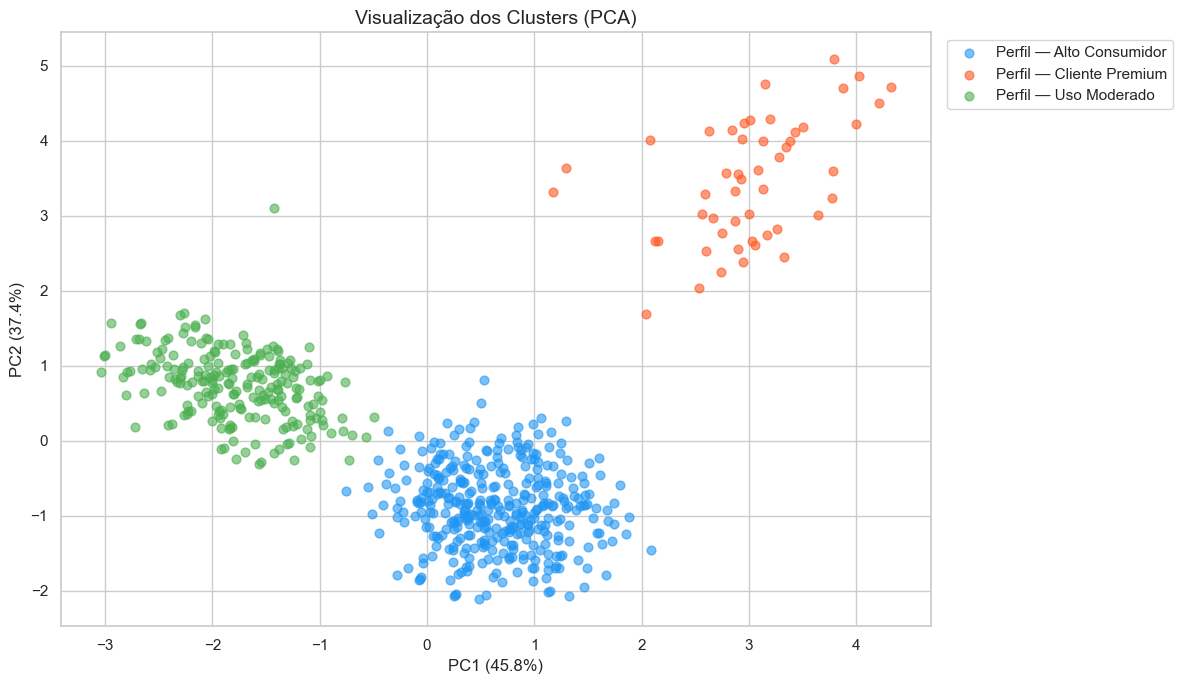

In [11]:
# 6. VISUALIZAÇÕES FINAIS

# 6.1 Clusters no PCA 2D

pca = PCA(n_components=2)
coords = pca.fit_transform(df_scaled)

df_plot = pd.DataFrame({
    'PC1': coords[:,0], 'PC2': coords[:,1],
    'Perfil': df_clean['Perfil']
})

plt.figure(figsize=(12, 7))
for i, (perfil_nome, grupo) in enumerate(df_plot.groupby('Perfil')):
    plt.scatter(grupo['PC1'], grupo['PC2'], 
                label=perfil_nome, color=PALETTE[i], alpha=0.6, s=40)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Visualização dos Clusters (PCA)', fontsize=14)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

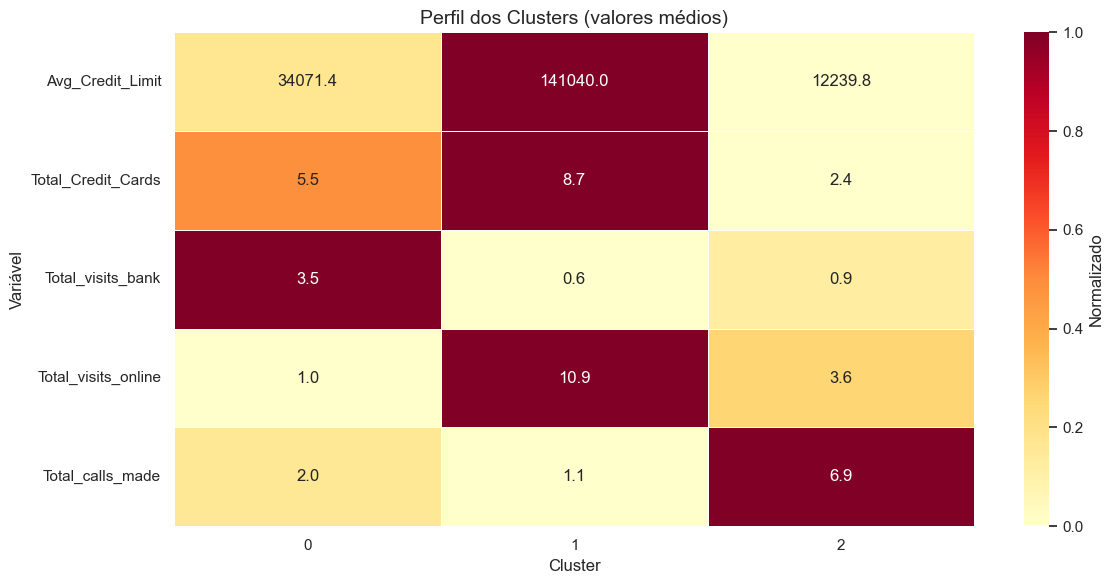

In [12]:
# 6.2 Heatmap de perfil

perfil_norm = perfil.copy()
scaler_mm = MinMaxScaler()
perfil_norm[num_cols] = scaler_mm.fit_transform(perfil[num_cols])

plt.figure(figsize=(12, 6))
sns.heatmap(perfil_norm.T, annot=perfil.T, fmt='.1f', 
            cmap='YlOrRd', linewidths=0.5, cbar_kws={'label': 'Normalizado'})
plt.title('Perfil dos Clusters (valores médios)', fontsize=14)
plt.ylabel('Variável')
plt.xlabel('Cluster')
plt.tight_layout()
plt.show()

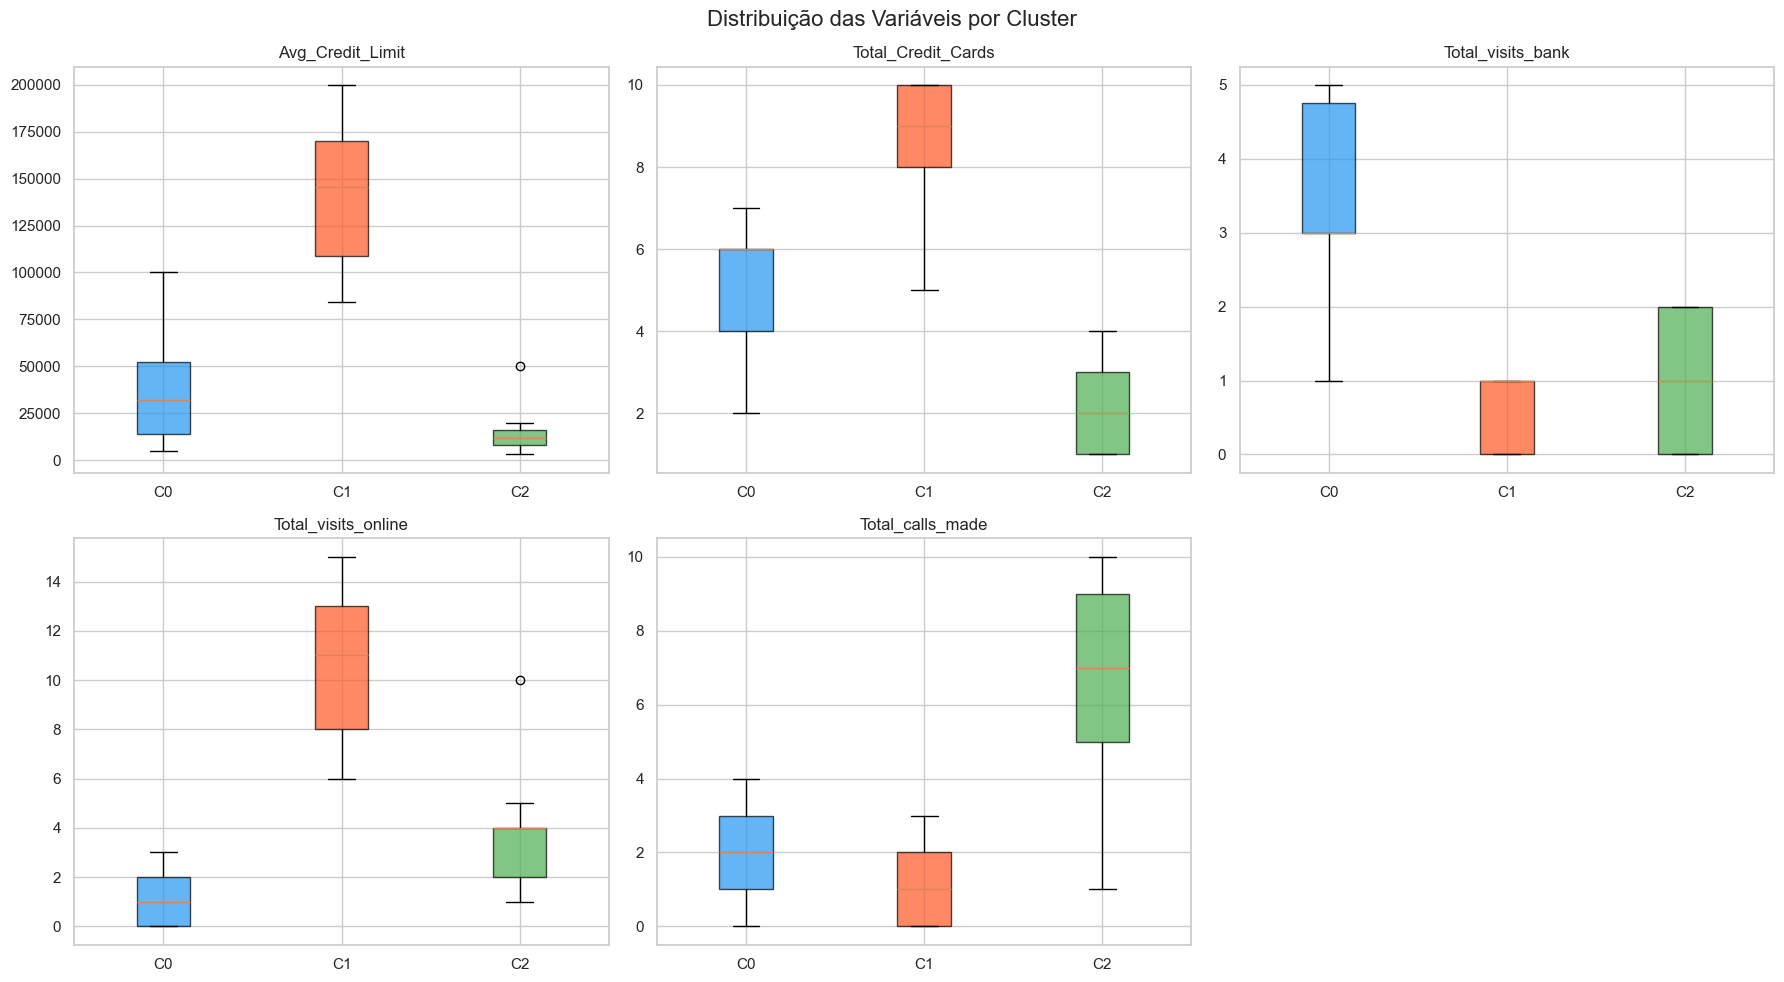

In [13]:
# 6.3 Boxplots comparativos

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    data = [df_clean[df_clean['Cluster'] == k][col].values for k in range(best_k)]
    bp = axes[i].boxplot(data, patch_artist=True)
    
    for patch, color in zip(bp['boxes'], PALETTE):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[i].set_title(col)
    axes[i].set_xticklabels(['C0', 'C1', 'C2'])

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distribuição das Variáveis por Cluster', fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
# 7. VALIDAÇÃO ESTATÍSTICA

print("\nVALIDAÇÃO KRUSKAL-WALLIS")
print("H0: clusters têm a mesma distribuição")
print("H1: pelo menos um cluster difere")
print(f"α = 0.05\n")

resultados = []
for col in num_cols:
    grupos = [df_clean[df_clean['Cluster'] == k][col].values for k in range(best_k)]
    stat, p = kruskal(*grupos)
    resultados.append([col, f"{stat:.3f}", f"{p:.4f}", "✓" if p < 0.05 else "✗"])

df_valid = pd.DataFrame(resultados, columns=['Variável', 'H', 'p-valor', 'Significativo'])
print(df_valid.to_string(index=False))

sig_count = sum(df_valid['Significativo'] == '✓')
print(f"\n{sig_count} de {len(num_cols)} variáveis são significativas; os clusters são estatisticamente diferentes entre si")


VALIDAÇÃO KRUSKAL-WALLIS
H0: clusters têm a mesma distribuição
H1: pelo menos um cluster difere
α = 0.05

           Variável       H p-valor Significativo
   Avg_Credit_Limit 259.080  0.0000             ✓
 Total_Credit_Cards 455.010  0.0000             ✓
  Total_visits_bank 429.505  0.0000             ✓
Total_visits_online 444.818  0.0000             ✓
   Total_calls_made 422.243  0.0000             ✓

5 de 5 variáveis são significativas; os clusters são estatisticamente diferentes entre si


In [15]:
# 8. INTERPRETAÇÃO FINAL
print("\n" + "="*70)
print("INTERPRETAÇÃO FINAL DOS CLUSTERS")
print("="*70)

perfil_dict = perfil.to_dict(orient='index')
for cluster in range(best_k):
    p = perfil_dict[cluster]
    nome = nomes[cluster].replace('Perfil — ', '')
    
    print(f"\n{nome.upper()}")
    print(f"   {dist[nomes[cluster]]} clientes ({dist[nomes[cluster]]/len(df_clean)*100:.1f}%)")
    print(f"   Limite médio: R$ {p['Avg_Credit_Limit']:,.0f}")
    print(f"   Cartões: {p['Total_Credit_Cards']:.1f}")
    print(f"   Visitas banco: {p['Total_visits_bank']:.1f}")
    print(f"   Visitas online: {p['Total_visits_online']:.1f}")
    print(f"   Ligações: {p['Total_calls_made']:.1f}")

print("\nRESUMO:")
print(""" A base tem 660 clientes, divididos em 3 perfis distintos.
 - Cluster 0 (Alto Consumidor): maior uso do banco físico e ligações.
 - Cluster 1 (Cliente Premium): maior limite e cartões, usa quase só online.
 - Cluster 2 (Uso Moderado): perfil intermediário, menos limite e uso equilibrado.
 - Validação estatística confirma que os clusters são diferentes entre si.
""")


INTERPRETAÇÃO FINAL DOS CLUSTERS

ALTO CONSUMIDOR
   378 clientes (58.2%)
   Limite médio: R$ 34,071
   Cartões: 5.5
   Visitas banco: 3.5
   Visitas online: 1.0
   Ligações: 2.0

CLIENTE PREMIUM
   50 clientes (7.7%)
   Limite médio: R$ 141,040
   Cartões: 8.7
   Visitas banco: 0.6
   Visitas online: 10.9
   Ligações: 1.1

USO MODERADO
   221 clientes (34.1%)
   Limite médio: R$ 12,240
   Cartões: 2.4
   Visitas banco: 0.9
   Visitas online: 3.6
   Ligações: 6.9

RESUMO:
 A base tem 660 clientes, divididos em 3 perfis distintos.
 - Cluster 0 (Alto Consumidor): maior uso do banco físico e ligações.
 - Cluster 1 (Cliente Premium): maior limite e cartões, usa quase só online.
 - Cluster 2 (Uso Moderado): perfil intermediário, menos limite e uso equilibrado.
 - Validação estatística confirma que os clusters são diferentes entre si.

